Importamos Librerias correspondientes para poder realizar el proceso EDA(Exploratory Data Analysis)

In [304]:
import pandas as pd
import pyarrow
import geopy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn import preprocessing
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree

Leemos el archivo parquet de 'train.parquet' con la función de read de Pandas

In [139]:
dataset_train_1 = pd.read_parquet('train.parquet', engine='pyarrow')

Eliminamos columnas innecesarias para el proceso


In [143]:
dataset_train_1.drop(columns=['url','id','region_url','image_url','lat','long','description'], inplace=True)
dataset_train_1.drop_duplicates(inplace=True)

Deseo ver cuantos valores unicos hay en ciertas columnas

In [ ]:
dataset_train_1['type'].unique()

In [ ]:
dataset_train_1['state'].unique()

In [ ]:
dataset_train_1['laundry_options'].unique()

In [ ]:
dataset_train_1['parking_options'].unique()

In [ ]:
dataset_train_1['region'].unique()

Utilizando Label Encoder y convierto las variables categóricas para poder utilizarlas en el modelo.

In [154]:
#Utilizando Label Encoder y convierto las variables categóricas para poder utilizarlas en el modelo.
le = preprocessing.LabelEncoder()

le.fit(dataset_train_1.type)
dataset_train_1.type = le.transform(dataset_train_1.type)

le.fit(dataset_train_1.state)
dataset_train_1.state = le.transform(dataset_train_1.state)

le.fit(dataset_train_1.laundry_options)
dataset_train_1.laundry_options = le.transform(dataset_train_1.laundry_options)

le.fit(dataset_train_1.parking_options)
dataset_train_1.parking_options = le.transform(dataset_train_1.parking_options)

le.fit(dataset_train_1.region)
dataset_train_1.region = le.transform(dataset_train_1.region)



Chequeamos por valores nulos y tambien valores unicos. 

In [128]:
# CHEQUEAR DUPLICADOS
dataset_train_1.duplicated().value_counts()

False    278633
dtype: int64

In [127]:
# ELIMINAMOS DUPLICADOS
dataset_train_1.drop_duplicates(inplace=True)

In [148]:
# Funcion para asignar categoria de precio 
def asignar(i):
    if i <= 999:
        return 'low'
    elif i <=1999:
        return 'medium'
    else:
        return 'high'

In [174]:
# Funcion para asignar categoria de precio con asociacion binaria
def asignar_bin(i):
    if i == 'low':
        return int(1)
    elif i == 'medium' or i == 'high':
        return int(0)
    

Aplicando la función definida, creo una nueva columna binaria según la categoria del precio.

In [149]:
dataset_train_1['category_price'] = dataset_train_1['price'].apply(asignar)
dataset_train_1['category_price_bin'] = dataset_train_1['category_price'].apply(asignar_bin)

DUPLICO EL DATAFRAME SIN LA COLUMNA DE LOW - MEDIUM - HIGH PARA ENTRENARLO

In [209]:
dataset_train_arbol = dataset_train_1.drop(columns=['category_price','price'])

In [297]:
#Defino X e y utilizando el dataframe resultante.
X = dataset_train_arbol.iloc[:,0:14]
y = dataset_train_arbol[['category_price']]

In [321]:
#Utilzando el train_test_split hago el split de los datos para luego entrenar el modelo de arbol con una profundidad de 4
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
arbol = DecisionTreeClassifier(max_depth = 4, random_state=42)
arbol.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

In [322]:
#Prediccion del modelo
y_train_pred = arbol.predict(X_test)
y_train_pred

array([0, 0, 1, ..., 0, 0, 0])

In [323]:
#Calculo el Recall y Accuracy del modelo.
accuracy_train = accuracy_score(y_test, y_train_pred)
print(f'Accuracy Train: {accuracy_train}')
recall_train = recall_score(y_test , y_train_pred)
print(f'Recall Train: {recall_train}')

Accuracy Train: 0.7309247517645652
Recall Train: 0.6337557994794614


Curva ROC Esta métrica nos indica cuán bien puede distinguir el modelo entre dos clases.

In [324]:
roc_auc=roc_auc_score(y_test,y_train_pred)
roc_auc

0.7179392156055737

Matriz de Confusión

In [325]:
print(confusion_matrix(y_test, y_train_pred))

[[38696  9546]
 [12946 22402]]


VERIFICO QUE LA CORRELACIÓN DE MIS VARIABLES PARA PODER OPTIMIZAR MI ALGORITMO 

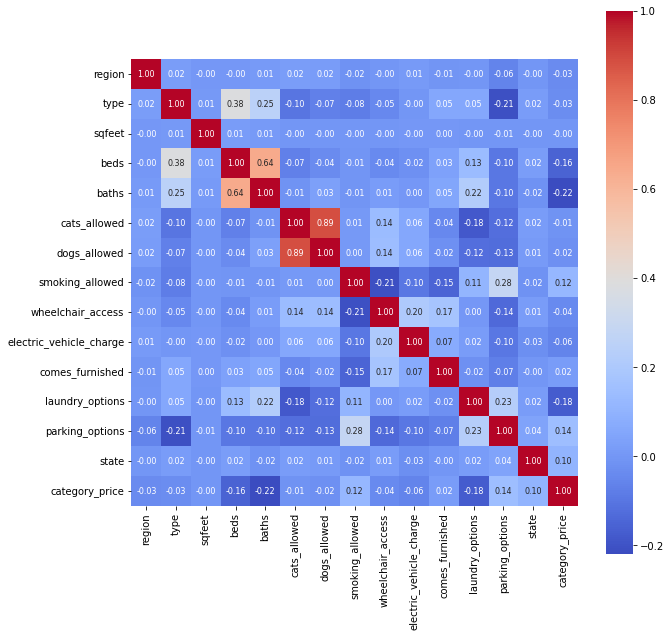

In [326]:
corr = dataset_train_arbol.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 8},
           xticklabels= dataset_train_arbol.columns, 
           yticklabels= dataset_train_arbol.columns,
           cmap= 'coolwarm')
plt.xticks
plt.yticks
plt.show()

Realizo una validación cruzada para poder visualizar posibles resultados con diferentes niveles de profundida

{'fit_time': array([0.34484816, 0.337147  , 0.31844306, 0.34232807, 0.33909988]), 'score_time': array([0.0186789 , 0.01933599, 0.01832318, 0.01980186, 0.01890612]), 'test_accuracy': array([0.73337879, 0.73205089, 0.72964631, 0.73084377, 0.72890572])}


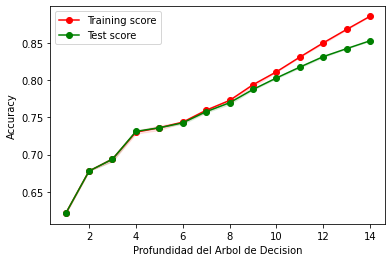

In [327]:
from sklearn.model_selection import cross_validate
arbol_scores = cross_validate(arbol, X, y, scoring = ['accuracy'])
print(arbol_scores)
tree_train_scores_mean = []
tree_train_scores_std = []
tree_test_scores_mean = []
tree_test_scores_std = []

profundidades = np.arange(1,15,1)

for profundidad in profundidades:
    clf = DecisionTreeClassifier(max_depth=profundidad)
    tree_scores = cross_validate(clf, X, y, cv=2, return_train_score=True, n_jobs = -1)
    
    tree_train_scores_mean.append(tree_scores['train_score'].mean())
    tree_train_scores_std.append(tree_scores['train_score'].std())
    
    tree_test_scores_mean.append(tree_scores['test_score'].mean())
    tree_test_scores_std.append(tree_scores['test_score'].std())

tree_train_scores_mean = np.array(tree_train_scores_mean)
tree_train_scores_std = np.array(tree_train_scores_std)
tree_test_scores_mean = np.array(tree_test_scores_mean)
tree_test_scores_std = np.array(tree_test_scores_std)
plt.fill_between(profundidades, tree_train_scores_mean - tree_train_scores_std,
                 tree_train_scores_mean + tree_train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(profundidades, tree_test_scores_mean - tree_test_scores_std,
                 tree_test_scores_mean + tree_test_scores_std, alpha=0.1, color="g")

plt.plot(profundidades, tree_train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(profundidades, tree_test_scores_mean, 'o-', color="g",
         label="Test score")


plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Profundidad del Arbol de Decision')
plt.show()

In [421]:
# Nuevo modelo con optima profundidad propuestaa por el crossvalidation

model = DecisionTreeClassifier(random_state=42, max_depth=9)
model.fit(X_train, y_train)
# Nueva Prediccion
y_train_pred_sel = model.predict(X_test)
y_train_pred_sel

array([0, 0, 1, ..., 0, 0, 1])

In [422]:
roc_auc=roc_auc_score(y_test,y_train_pred_sel)
print(f'Area bajo la curva: {roc_auc}')
accuracy_train = accuracy_score(y_test, y_train_pred_sel)
print(f'Accuracy Train: {accuracy_train}')
recall_train = recall_score(y_test, y_train_pred_sel)
print(f'Recall Train: {recall_train}')

Area bajo la curva: 0.7850444140595773
Accuracy Train: 0.7876659887546357
Recall Train: 0.7680491116894874


PIPELINE

In [342]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [343]:
pipe_lr = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', LogisticRegression(random_state=42))])

pipe_dt = Pipeline([('scl', StandardScaler()),
			('pca', PCA(n_components=2)),
			('clf', tree.DecisionTreeClassifier(random_state=42))])

In [344]:
pipelines = [pipe_lr, pipe_dt]
pipe_dict = {0: 'Regresión Logística', 1: 'Árbol de decisión'}

In [346]:
pipe_lr.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('scl', StandardScaler()), ('pca', PCA(n_components=2)),
                ('clf', DecisionTreeClassifier(random_state=42))])

In [347]:
for idx, val in enumerate(pipelines):
	print('%s pipeline accuracy en test: %.3f' % (pipe_dict[idx], val.score(X_test, y_test)))

Regresión Logística pipeline accuracy en test: 0.624
Árbol de decisión pipeline accuracy en test: 0.788


El Arbol de decisión tiene mejor resultado de Accuracy

In [335]:
import joblib

joblib.dump(model, 'DecisionTree_model.pkl', compress=1)

['DecisionTree_model.pkl']

In [338]:
DecisionTree_model = joblib.load('DecisionTree_model.pkl')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [340]:
DecisionTree_model.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=9, random_state=42)

In [339]:
DecisionTree_model.score(X_test, y_test)

0.7876659887546357

Realizamos el proceso en el archivo test.parquet

In [407]:
dataset_test_1 = pd.read_parquet('test.parquet', engine='pyarrow')

Elimino las columnas que no considere necesarias


In [408]:
dataset_test_1.drop(columns=['url','id','region_url','image_url','lat','long','description'], inplace=True)


Utilizando Label Encoder convierto las variables categóricas para poder utilizarlas en el modelo.

In [409]:
le = preprocessing.LabelEncoder()

le.fit(dataset_test_1.type)
dataset_test_1.type = le.transform(dataset_test_1.type)

le.fit(dataset_test_1.state)
dataset_test_1.state = le.transform(dataset_test_1.state)

le.fit(dataset_test_1.laundry_options)
dataset_test_1.laundry_options = le.transform(dataset_test_1.laundry_options)

le.fit(dataset_test_1.parking_options)
dataset_test_1.parking_options = le.transform(dataset_test_1.parking_options)

le.fit(dataset_test_1.region)
dataset_test_1.region = le.transform(dataset_test_1.region)

In [410]:
#Creamos la columna 'category_price'
dataset_test_1['pred'] = ''

In [411]:
#Defino la X de hospitalizaciones_test
X_predic=dataset_test_1.iloc[:,0:14]

In [412]:
pred = DecisionTree_model.predict(X_predic)

In [405]:

dataset_test_1['pred']=pred
dataset_test_1=dataset_test_1['pred']

Exportamos el resultado de la columna 'PRED' a un archivo CSV

In [394]:
dataset_test_1.to_csv('FacundoArc.csv',index=False)